### To do:

==> Data augmentation


==> fine tuning in the training algorithm

# Land Cover Type Classification with PyTorch

This notebook serves as a starting point for your machine learning project on land cover type classification.

The task at hand involves classifying land cover types, such as 'Forest,' 'River,' 'Highway,' and more, based on satellite images. The dataset consists of images labeled with their corresponding land cover types. The goal is to train a machine learning model that can accurately predict the land cover type of new, unseen images.

In this notebook, you'll find code snippets to load and visualize the data, providing insights into the images and their labels.

## Build Your Model

You have the freedom to choose the architecture or model for your land cover classification task. Whether you opt for a simple convolutional neural network (CNN) or explore transfer learning with pre-trained models, the notebook provides a flexible starting point. Experiment with different architectures to achieve the best performance.

## Model Training and Evaluation

Once your model is defined, the notebook guides you through the process of training it on the dataset. Additionally, it includes code to evaluate the model's performance on the validation and test sets.

Feel free to modify, experiment, and enhance the provided code. Happy coding !

Please submit your weekly assignments to me via [email](mailto:elmontassir@cerfacs.fr) to receive your score on the test set.



# Data

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset, ConcatDataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tarfile
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# Check GPU availability
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("You are on GPU !")
else:
  print('Change the runtime to GPU or continue witch CPU, but this should slow down your trainings')
  device = torch.device("cpu")

Change the runtime to GPU or continue witcv h CPU, but this should slow down your trainings


In [3]:
# Loading the dataset
!wget -nv https://cerfacs.fr/opendata/cours/data/TRAIN.tar
!wget -nv https://cerfacs.fr/opendata/cours/data/TEST.tar
!wget -nv https://cerfacs.fr/opendata/cours/data/y_train.npy

2023-12-23 16:31:58 URL:https://cerfacs.fr/opendata/cours/data/TRAIN.tar [44851200/44851200] -> "TRAIN.tar.8" [1]
2023-12-23 16:32:00 URL:https://cerfacs.fr/opendata/cours/data/TEST.tar [15687680/15687680] -> "TEST.tar.8" [1]
2023-12-23 16:32:01 URL:https://cerfacs.fr/opendata/cours/data/y_train.npy [1600128/1600128] -> "y_train.npy.8" [1]


In [3]:
# Using tarfile to create np arrays
def extract_files(dataset):
    tar = tarfile.open(dataset+'.tar', 'r')
    names = tar.getmembers()[:]
    images = [tar.extractfile(name) for name in names]
    return np.array([np.array(Image.open(image)) for image in images])

In [4]:
X_train = extract_files('TRAIN')
X_test = extract_files('TEST')
y_train = np.load('y_train.npy').reshape(-1, 1)
print("Train data : ",X_train.shape)
print("Train labels", y_train.shape)
print("Test data : ",X_test.shape)

Train data :  (20000, 64, 64, 3)
Train labels (20000, 1)
Test data :  (7000, 64, 64, 3)


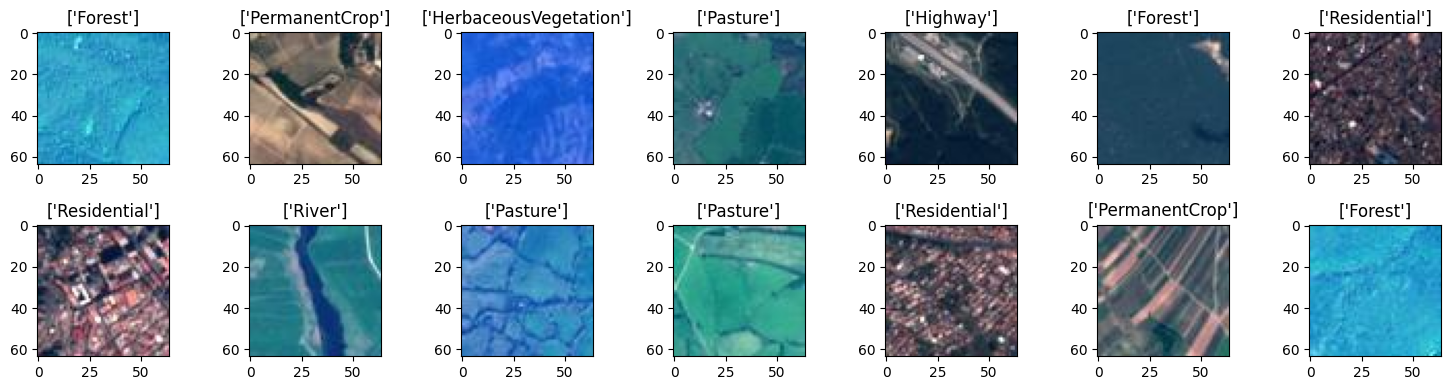

In [5]:
# Display data samples
fig, axes = plt.subplots(2, 7, figsize=(15, 4))
axes = axes.ravel()
for i in range(14):
    axes[i].imshow(X_train[i])
    axes[i].set_title(y_train[i])
plt.tight_layout()

There are 10 possible classes for each image (only one per image is correct):

  - 'AnnualCrop'
  - 'Forest'
  - 'HerbaceousVegetation'
  - 'Highway'
  - 'Industrial'
  - 'Pasture'
  - 'PermanentCrop'
  - 'Residential'
  - 'River'
  - 'SeaLake'

We could simply code an integer value for each: 'AnnualCrop' = 0, 'Forest' = 1, etc... This is known as "Ordinal Encoding", and has some drawbacks, e.g. if the network is unsure whether it is class 0 or 2, it could end up saying 1, which is another class altogether. When categories have a natural order, ordinal encoding can be a good way to go. Here, this is not the case.

The most classical way to convert the type of labels here to numeric values is through [**one-hot encoding**](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-categorical-features). In this process, the label is converted to a vector with length the number of possible labels, and only the one matching the true label is set to 1, all others are set to 0.

|                 | Type1 | Type2 | Type3 |   | Label Vector |
|-----------------|:-----:|:-----:|:-----:|---|:------------:|
| Sample1: Type 2 |   0   |   1   |   0   |   |   [0, 1, 0]  |
| Sample2: Type 2 |   0   |   1   |   0   |   |   [0, 1, 0]  |
| Sample3: Type 1 |   1   |   0   |   0   |   |   [1, 0, 0]  |
| ...             |       |       |       |   |              |

Scikit-learn has a useful class for this, [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), which does this automatically. More importantly, it remembers the encoding, and you can use it again after making your final predictions te *decode* them back to text labels, as expected by the competition.

##The generated images:

In [6]:
def data_augmentation(image):
    image_pil = Image.fromarray(np.uint8(image))
    transformed_image = transforms.Compose([
        transforms.RandomRotation(45),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    ])(image_pil)
    return np.array(transformed_image)



In [7]:
X_train_augmented1 = np.array([data_augmentation(image) for image in X_train])

In [8]:
X_train_new = np.concatenate([X_train_augmented1], axis=0)

In [9]:
y_train_new = np.concatenate([y_train, y_train], axis=0)

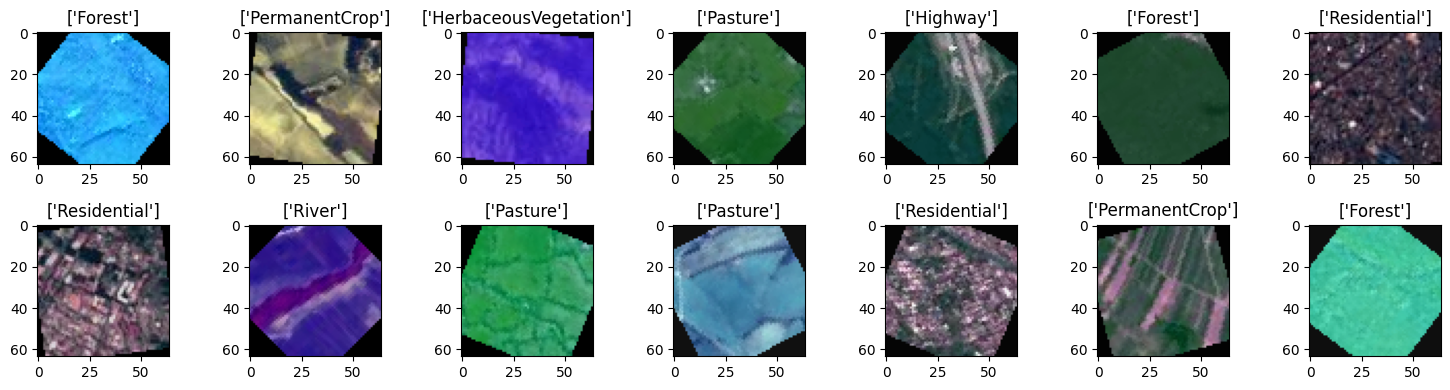

In [11]:
fig, axes = plt.subplots(2, 7, figsize=(15, 4))
axes = axes.ravel()
for i in range(14):
    axes[i].imshow(X_train_new[i])
    axes[i].set_title(y_train_new[i])
plt.tight_layout()

In [13]:
# Convert labels to one-hot encoding
encoder = OneHotEncoder()
y_train_new = encoder.fit_transform(y_train).toarray()
y_train_new

array([[1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 1., ..., 0., 1., 0.],
       [1., 0., 1., ..., 0., 1., 0.],
       ...,
       [1., 0., 1., ..., 0., 1., 0.],
       [1., 0., 1., ..., 1., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.]])

In [14]:
# l=np.array([[1,1,2],[1,1,2],[2,2,2]])
# h=np.array([[1,1,3],[1,1,3],[2,2,3]])
# k=np.array([[1,1,4],[1,1,4],[2,2,4]])
# f = np.concatenate([l,h,k], axis=0)

np.save('/content/X_train_new.npy', X_train_new)


In [15]:
np.save('/content/y_train_new.npy', y_train_new)

# Model

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset, ConcatDataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tarfile
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
# Using tarfile to create np arrays
def extract_files(dataset):
    tar = tarfile.open(dataset+'.tar', 'r')
    names = tar.getmembers()[:]
    images = [tar.extractfile(name) for name in names]
    return np.array([np.array(Image.open(image)) for image in images])

In [4]:
# Loading the dataset
!wget -nv https://cerfacs.fr/opendata/cours/data/TRAIN.tar
!wget -nv https://cerfacs.fr/opendata/cours/data/TEST.tar
!wget -nv https://cerfacs.fr/opendata/cours/data/y_train.npy

2023-12-23 16:54:47 URL:https://cerfacs.fr/opendata/cours/data/TRAIN.tar [44851200/44851200] -> "TRAIN.tar.9" [1]
2023-12-23 16:54:48 URL:https://cerfacs.fr/opendata/cours/data/TEST.tar [15687680/15687680] -> "TEST.tar.9" [1]
2023-12-23 16:54:49 URL:https://cerfacs.fr/opendata/cours/data/y_train.npy [1600128/1600128] -> "y_train.npy.9" [1]


In [5]:
X_test = extract_files('TEST')
print("Test data : ",X_test.shape)

Test data :  (7000, 64, 64, 3)


In [7]:
X_train_new = np.load('/content/X_train_new.npy')


In [8]:
y_train_new = np.load('/content/y_train_new.npy')

Note: the images here are encoded with 8-bit integers, *i.e.* between 0 and 255. A normalization is needed.

In [9]:
# Prepare data for training
X_train_new, X_test = X_train_new/255, X_test/255
mean = np.mean(X_train_new, axis=(0, 1, 2))
std = np.std(X_train_new, axis=(0, 1, 2))
print(mean)
print(std)

[0.26728878 0.35183635 0.40193361]
[0.22803128 0.24552087 0.25007797]


The normalization coefficients for the mean and standard deviation are commonly used for image data normalization within the range of [0, 255] or [0, 1]. This process brings pixel values into a standard range centered around zero, facilitating the acceleration of neural network training. In this case, we begin by dividing by 255 to scale values to [0, 1]. Subsequently, subtracting the mean centers the range around zero, and dividing by the standard deviation reduces the range to a centered Gaussian distribution, promoting stability.

Normalization coefficients may vary depending on the dataset, image characteristics, and network architecture. Experimenting with different strategies is common in model development. For specific datasets, calculating the mean and standard deviation directly from the training data can provide a good normalization.

In [ ]:
# Assuming X_train and y_train are PyTorch tensors
X_train_new, X_valid_new, y_train_new, y_valid_new = train_test_split(X_train_new, y_train_new, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors and normalize images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

X_train_tensor_new = torch.stack([transform(img) for img in X_train_new]).float()
X_valid_tensor_new = torch.stack([transform(img) for img in X_valid_new]).float()
X_test_tensor = torch.stack([transform(img) for img in X_test]).float()
y_train_tensor_new = torch.from_numpy(y_train_new)
y_valid_tensor_new = torch.from_numpy(y_valid_new)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
# # Define the simple CNN model
# class SimpleCNN(nn.Module):
#     def __init__(self):
#         super(SimpleCNN, self).__init__()
#         self.conv_2 = nn.Conv2d(3, 4, kernel_size=3, stride=1, padding=1)
#         self.conv_1 = nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1)
#         self.conv0 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
#         self.conv1 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1) #outputs 64*64 -> 32*32 (max pooling)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=2, stride=2, padding=2) #outputs 18*18 -> 9*9 (max pooling)
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  #outputs 9*9
#         self.fc1 = nn.Linear(128*9*9, 50)  # Calculate the input size for fc1
#         self.fc2 = nn.Linear(50, 10)

#     def forward(self, x):
#         x = F.relu(self.conv_2(x))
#         x = F.relu(self.conv_1(x))
#         x = F.relu(self.conv0(x))
#         x = F.relu(self.conv1(x))
#         x = F.max_pool2d(x, 2)  # Apply max pooling after the first convolutional layer
#         x = F.relu(self.conv2(x))
#         x = F.max_pool2d(x, 2)  # Apply max pooling after the first convolutional layer
#         x = F.relu(self.conv3(x))
#         x = x.view(-1, 9*9*128)  # Flatten the output before the fully connected layers
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         return F.log_softmax(x, dim=1)

In [18]:
import torchvision.models as models

# Load the pre-trained GoogleNet model
googlenet = models.googlenet(pretrained=True)

# Print the model architecture

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
# Instantiate the model
model = googlenet.to(device)

# Print the model architecture
print(model)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())  # You can set learning rate, weight decay, etc.

# Training loop
num_epochs = 15
batch_size = 30

train_dataset = TensorDataset(X_train_tensor, y_train_tensor.argmax(dim=1))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor.argmax(dim=1))
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [25]:
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        valid_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = correct / total
    print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {valid_loss / len(valid_loader):.3f}, Accuracy: {100*accuracy:.2f}%')

KeyboardInterrupt: ignored

# Create Your Submission

In [ ]:
# Function to create a submission file
def create_submission(predictions):
    assert predictions.shape == (7000, 1), f"Wrong shape for your prediction file : {predictions.shape} instead of (7000, 1)"
    with open('predictions.npy', 'wb') as f:
      np.save(f, predictions)
    print("File predictions.npy created !")

In [ ]:
# Generate predictions
bs = 35
predictions = np.ones((X_test_tensor.shape[0],10))
for i in range(X_test_tensor.shape[0]//bs):
  predictions[bs*i:bs*(i+1),:] = model(X_test_tensor[bs*i:bs*(i+1)].to(device)).cpu().detach().numpy()
print(predictions[:5])

# Get labels
predictions = encoder.inverse_transform(predictions)
print(predictions[:5])

# Create a submission using the provided function
NAME = "Haliloua_Othmane"
NUMBER = 1
create_submission(predictions)

[[-6.09532166e+00 -2.50132751e+00 -7.26992178e+00 -6.95394516e+00
  -1.03479290e+01 -1.61762202e+00 -1.03479290e+01 -1.03479290e+01
  -3.34603906e-01 -1.03479290e+01]
 [-1.64609776e+01 -1.64609776e+01 -1.26018114e+01 -1.03978329e+01
  -5.70996199e-05 -1.64609776e+01 -1.06865063e+01 -1.64609776e+01
  -1.64609776e+01 -1.64609776e+01]
 [-8.56722546e+00 -1.61687469e+01 -5.49280310e+00 -3.71144247e+00
  -1.61687469e+01 -4.65307283e+00 -3.90334763e-02 -1.61687469e+01
  -1.61687469e+01 -1.61687469e+01]
 [-1.13785334e+01 -1.23976897e-05 -1.43724594e+01 -1.81137199e+01
  -1.81137199e+01 -1.81137199e+01 -1.81137199e+01 -1.81137199e+01
  -1.77818718e+01 -1.47404623e+01]
 [-1.15366154e+01 -1.14807968e+01 -6.93502855e+00 -5.04304743e+00
  -1.15366154e+01 -1.03082666e+01 -9.49645424e+00 -1.15366154e+01
  -7.61404308e-03 -1.15366154e+01]]
[['River']
 ['Industrial']
 ['PermanentCrop']
 ['Forest']
 ['River']]
File predictions.npy created !


In [ ]:
# Function to create a submission file
def create_submission(filename,predictions):
    assert predictions.shape == (7000, 1), f"Wrong shape for your prediction file : {predictions.shape} instead of (7000, 1)"
    with open(f'{filename}.npy', 'wb') as f:
      np.save(f, predictions)
    print("File predictions.npy created !")

In [ ]:

# Use the following code in the submission cell of your project notebook
# Generate predictions
bs = 35
predictions = np.ones((X_test_tensor.shape[0],10))
for i in range(X_test_tensor.shape[0]//bs):
  predictions[bs*i:bs*(i+1),:] = model(X_test_tensor[bs*i:bs*(i+1)].to(device)).cpu().detach().numpy()
print(predictions[:5])

# Get labels
predictions = encoder.inverse_transform(predictions)
print(predictions[:5])

# Create a submission using the provided function
NAME = "Haliloua"
from datetime import datetime
# Get the current date
current_date = datetime.now()
# Format the date as MM_DD_YY
formatted_date = current_date.strftime("%m_%d_%y")

create_submission(f"{NAME}_{formatted_date}",predictions)

[[-6.09532166e+00 -2.50132751e+00 -7.26992178e+00 -6.95394516e+00
  -1.03479290e+01 -1.61762202e+00 -1.03479290e+01 -1.03479290e+01
  -3.34603906e-01 -1.03479290e+01]
 [-1.64609776e+01 -1.64609776e+01 -1.26018114e+01 -1.03978329e+01
  -5.70996199e-05 -1.64609776e+01 -1.06865063e+01 -1.64609776e+01
  -1.64609776e+01 -1.64609776e+01]
 [-8.56722546e+00 -1.61687469e+01 -5.49280310e+00 -3.71144247e+00
  -1.61687469e+01 -4.65307283e+00 -3.90334763e-02 -1.61687469e+01
  -1.61687469e+01 -1.61687469e+01]
 [-1.13785334e+01 -1.23976897e-05 -1.43724594e+01 -1.81137199e+01
  -1.81137199e+01 -1.81137199e+01 -1.81137199e+01 -1.81137199e+01
  -1.77818718e+01 -1.47404623e+01]
 [-1.15366154e+01 -1.14807968e+01 -6.93502855e+00 -5.04304743e+00
  -1.15366154e+01 -1.03082666e+01 -9.49645424e+00 -1.15366154e+01
  -7.61404308e-03 -1.15366154e+01]]
[['River']
 ['Industrial']
 ['PermanentCrop']
 ['Forest']
 ['River']]
File predictions.npy created !
